In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',parse_dates=['date'], index_col='date')



# Extract the trend and the seasonality from the time serie

In [2]:
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

In [3]:
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed['product'] = (df_reconstructed['seas']*df_reconstructed['trend']*df_reconstructed['resid'])

# Forecasting model

## Forecasting the trend

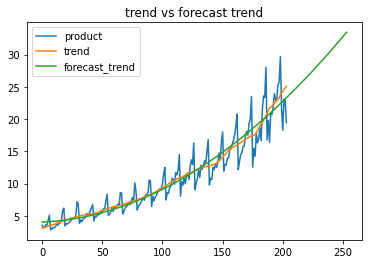

In [4]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

N=50
def trend_forecasting(model_trend=LinearRegression(),N_forecast = N ):
    model = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), model_trend )
    y = df_reconstructed['trend']
    x = [[i] for i in range(len(y))]
    model.fit(x,y)
    x_pred = [[i] for i in range(len(y) + N_forecast)]
    y_pred = model.predict(x_pred)
    return y_pred

### get the trend from the forecasting function
y_pred = trend_forecasting()
df_forecast = pd.DataFrame()
df_forecast['forecast_trend'] = y_pred 

###change datatimeindex to rangeindex
df_reconstructed.index = pd.RangeIndex(start=0, stop=len(df_reconstructed['trend']), step=1)
df_forecast.index = pd.RangeIndex(start=0, stop=len(df_reconstructed['trend'])+N, step=1)

### plot the forecast trend ###
plt.figure()
plt.title('trend vs forecast trend')
df_reconstructed['product'].plot()
df_reconstructed['trend'].plot()
df_forecast['forecast_trend'].plot()
plt.legend()
plt.show()

## Forecasting the seasonality

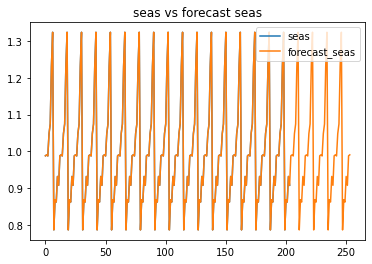

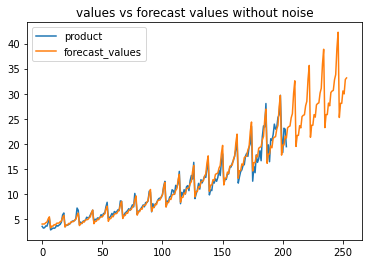

In [61]:
#forecasting seasonality
from sklearn.ensemble import RandomForestRegressor
def seas_forecasting(model_seas=RandomForestRegressor(), N_forecast=N, period=12):
    model = make_pipeline(StandardScaler(), model_seas)
    y = df_reconstructed['seas']
    x = [[i%period] for i in range(len(y))]
    model.fit(x,y)
    x_pred = [[i%period] for i in range(len(y) + N_forecast)]
    y_pred = model.predict(x_pred)
    return y_pred

### get the seasonality from the forecasting function
y_pred = seas_forecasting()
df_forecast['forecast_seas'] = y_pred 

###reconstruct a signal
df_forecast['forecast_values'] = df_forecast['forecast_trend']+df_forecast['forecast_seas']

### plot the forecast seasonality ###
plt.figure()
plt.title('seas vs forecast seas')
df_reconstructed['seas'].plot()
df_forecast['forecast_seas'].plot()
plt.legend()
plt.show()

### plot the forecast without noise ###
plt.figure()
plt.title('values vs forecast values without noise')
df_reconstructed['product'].plot()
df_forecast['forecast_values'].plot()
plt.legend()
plt.show()